
# Imports

In [2]:
import pandas
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
from pysal.lib import weights
from pysal.explore import esda
import seaborn
from splot import esda as esdaplot

### Basic cleaning

In [3]:
#  Data loading
gdp_df = pandas.read_csv("data/GDP(Nuts2)/nama_10r_2gdp_linear.csv")

# Choosing a unit - PPS (Purchasing Power Standards) per inhabitant
gdp_df = gdp_df[gdp_df['unit']=='PPS_EU27_2020_HAB']
gdp_df

,DATAFLOW,LAST UPDATE,freq,unit,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG
50098,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,AL,2008,6400.0,NaN
50099,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,AL,2009,6700.0,NaN
50100,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,AL,2010,7300.0,NaN
50101,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,AL,2011,7600.0,NaN
50102,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,AL,2012,7800.0,NaN
...,...,...,...,...,...,...,...,...
59632,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,TRC3,2018,9500.0,NaN
59633,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,TRC3,2019,9500.0,NaN
59634,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,TRC3,2020,9700.0,NaN
59635,ESTAT:NAMA_10R_2GDP(1.0),20/02/24 11:00:00,A,PPS_EU27_2020_HAB,TRC3,2021,10100.0,NaN


In [4]:
# Renaming geo column
gdp_df.rename(columns={'geo': 'NUTS_ID'}, inplace=True)
gdp_df.rename(columns={'OBS_VALUE': 'GDP_VALUE'}, inplace=True)

In [5]:
# Removing unnecessary columns (only one value for all rows)
gdp_df = gdp_df.drop(columns=['DATAFLOW','LAST UPDATE','freq', 'unit', 'OBS_FLAG'])

In [6]:
# Checking datatype of columns
# Check the current data types
print(gdp_df['NUTS_ID'].dtype)
print(gdp_df['TIME_PERIOD'].dtype)
print(gdp_df['GDP_VALUE'].dtype)

# Convert all values to a specific type (e.g., int)
gdp_df['NUTS_ID'] = gdp_df['NUTS_ID'].astype(object)
gdp_df['TIME_PERIOD'] = gdp_df['TIME_PERIOD'].astype(str)
gdp_df['GDP_VALUE'] = gdp_df['GDP_VALUE'].astype(float)

object
int64
float64


In [7]:
# Checking for NaN values per column
nan_counts_per_column = gdp_df.isna().sum()
print(nan_counts_per_column)

NUTS_ID        0
TIME_PERIOD    0
GDP_VALUE      0
dtype: int64


### Checking years data per region

In [8]:
geo_year_dict = {}
# Creating a dictionary of the years corresponding to each geo area code
# Iterate over each row in the DataFrame
for index, row in gdp_df.iterrows():
    geo = row['NUTS_ID']
    year = row['TIME_PERIOD']

    # Check if geo already exists in the dictionary
    if geo in geo_year_dict:
        # If yes, append the year to the list of years for that geo
        geo_year_dict[geo].append(year)
    else:
        # If no, create a new list with the year and assign it to the geo key
        geo_year_dict[geo] = [year]

In [9]:
# Finding which years are found in all geo area codes!
# Create an empty set to store the years found in all geo areas
common_years = set()

# Flag to track if it's the first iteration
first_iteration = True

# Iterate over each row in the DataFrame
for index, row in gdp_df.iterrows():
    # Extract the 'TIME_PERIOD' value
    year = row['TIME_PERIOD']

    # For the first iteration, initialize common_years with the years from the first geo area
    if first_iteration:
        common_years.update(geo_year_dict[row['NUTS_ID']])
        first_iteration = False
    else:
        # For subsequent iterations, intersect common_years with the years from the current geo area
        common_years.intersection_update(geo_year_dict[row['NUTS_ID']])

# Print the common years found in all geo areas
print(sorted(common_years))

['2014', '2015', '2016', '2017', '2018', '2019']


# Spatial Autocorrelation (for one year - 2021)

### Merging with shapefile data

In [11]:
# Extracting only year 2021
gdp_2021_df = gdp_df[gdp_df['TIME_PERIOD'] == "2004"]
gdp_2021_df

,NUTS_ID,TIME_PERIOD,GDP_VALUE
50172,AT,2004,27600.0
50195,AT1,2004,29100.0
50218,AT11,2004,18900.0
50241,AT12,2004,22600.0
50264,AT13,2004,37100.0
...,...,...,...
59542,TRB2,2004,3200.0
59561,TRC,2004,4400.0
59580,TRC1,2004,5200.0
59599,TRC2,2004,4200.0


In [12]:
# Reading the shapefile data (ESPG:3035 - projected CRS needed for centroid calculation!)
gdf_3035 = gpd.read_file("data/NUTS_RG_20M_2021_3035.shp/NUTS_RG_20M_2021_3035.shp")

# Reading the shapefile data (ESPG:4326 - GEOGRAPHIC COORDINATE SYSTEM)
gdf_4326 = gpd.read_file("data/NUTS_RG_20M_2021_4326.shp/NUTS_RG_20M_2021_4326.shp")

# Merging gdp_2021 data with shapefile data
merged_df = pandas.merge(gdp_2021_df, gdf_3035, on='NUTS_ID', how='left')

# Extracting ONLY nuts level 2 regions!
merged_lvl2_df = merged_df[merged_df['LEVL_CODE']== 2.0]
merged_lvl2_df

,NUTS_ID,TIME_PERIOD,GDP_VALUE,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
2,AT11,2004,18900.0,2.0,AT,Burgenland,Burgenland,0.0,0.0,0.0,AT11,"POLYGON ((4846489.857 2803511.391, 4854633.294..."
3,AT12,2004,22600.0,2.0,AT,Niederösterreich,Niederösterreich,0.0,0.0,0.0,AT12,"POLYGON ((4742889.368 2876362.725, 4783217.798..."
4,AT13,2004,37100.0,2.0,AT,Wien,Wien,0.0,0.0,0.0,AT13,"POLYGON ((4810026.316 2802881.310, 4780681.630..."
6,AT21,2004,23100.0,2.0,AT,Kärnten,Kärnten,0.0,0.0,0.0,AT21,"POLYGON ((4522751.261 2668742.613, 4555161.946..."
7,AT22,2004,24200.0,2.0,AT,Steiermark,Steiermark,0.0,0.0,0.0,AT22,"POLYGON ((4760796.641 2734593.840, 4780029.485..."
...,...,...,...,...,...,...,...,...,...,...,...,...
405,TRB1,2004,4900.0,2.0,TR,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",0.0,0.0,0.0,TRB1,"POLYGON ((6874779.807 2348344.184, 6890718.965..."
406,TRB2,2004,3200.0,2.0,TR,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",0.0,0.0,0.0,TRB2,"POLYGON ((7079743.967 2368049.187, 7090192.978..."
408,TRC1,2004,5200.0,2.0,TR,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",0.0,0.0,0.0,TRC1,"POLYGON ((6820569.117 2163902.580, 6827627.296..."
409,TRC2,2004,4200.0,2.0,TR,"Şanlıurfa, Diyarbakır","Şanlıurfa, Diyarbakır",0.0,0.0,0.0,TRC2,"POLYGON ((6989716.599 2273670.524, 6982786.486..."


In [13]:
# Check the geometry types
# Count the number of rows for each geometry type
geometry_type_counts = merged_lvl2_df['geometry'].apply(lambda geom: geom.type).value_counts()
print(geometry_type_counts)

# Filter out to include only POLYGON geometries (remove MULTIPOLYGON)

geometry
Polygon         214
MultiPolygon     59
Name: count, dtype: int64


C:\Users\20211147\AppData\Local\Temp\ipykernel_15204\4135085316.py:3: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  geometry_type_counts = merged_lvl2_df['geometry'].apply(lambda geom: geom.type).value_counts()


NOTE: NEED TO FIGURE OUT HOW TO DO THIS - Preprocessing of the shapefile data included converting the multipolygons into polygons. The semantic interpretation of this process is "collapsing all the constituent Polygons into a single Polygon. This means that any holes or islands within the original MultiPolygon will be lost, and only the outer boundary (exterior ring) will remain" - "this conversion may be appropriate in certain situations, such as when you're only interested in the overall shape of the feature and not concerned with its internal structure.

* REMOVING ALL MULTIPOLYGONS - leads to so few data points!

In [14]:
from shapely.geometry import mapping

# Check geometry validity
invalid_geoms = merged_lvl2_df[~merged_lvl2_df['geometry'].apply(lambda geom: geom.is_valid)]

# Convert invalid geometries to GeoJSON format for visualization
invalid_geojson = invalid_geoms.geometry.apply(mapping)

# Print information about invalid geometries
print("Number of invalid geometries:", len(invalid_geoms))
print("Invalid geometries:")
print(invalid_geoms)

Number of invalid geometries: 0
Invalid geometries:
Empty DataFrame
Columns: [NUTS_ID, TIME_PERIOD, GDP_VALUE, LEVL_CODE, CNTR_CODE, NAME_LATN, NUTS_NAME, MOUNT_TYPE, URBN_TYPE, COAST_TYPE, FID, geometry]
Index: []


### Interactive map of GDP across NUTS 2

In [15]:
# Create a GeoDataFrame
gdf_lvl2 = gpd.GeoDataFrame(merged_lvl2_df, geometry='geometry')

In [16]:
# Center coordinates for the map
eu_center = [50.8503, 4.3517]

# Create a folium map centered on the EU center
m = folium.Map(location=eu_center, zoom_start=4)

# Add choropleth layer with GDP values
folium.Choropleth(
    geo_data=gdf_lvl2,
    data=gdf_lvl2,
    columns=['NUTS_ID', 'GDP_VALUE'],
    key_on='feature.properties.NUTS_ID',
    fill_color='OrRd',  # Color scale
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='GDP Value',
    highlight=True,
    name='GDP Choropleth',
).add_to(m)

# Add GeoJSON layer with tooltip
folium.GeoJson(
    gdf_lvl2,
    name='geojson',
    tooltip=folium.features.GeoJsonTooltip(fields=['NUTS_ID', 'GDP_VALUE'], labels=True, sticky=False)
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)

# Display the map
m

## Spatial Weight Matrix (W)

### Centroid Calculation

In [27]:
# Selecting only the required columns
gdf_lvl2 = gdf_lvl2[['NUTS_ID', 'NUTS_NAME', 'NAME_LATN', 'GDP_VALUE', 'geometry']].copy()

# Now, calculate the centroids (but float values!)
gdf_lvl2['centroid_lon'] = gdf_lvl2.geometry.centroid.x
gdf_lvl2['centroid_lat'] = gdf_lvl2.geometry.centroid.y

In [28]:
# Create a new geometry column for the centroids
gdf_lvl2['centroid_geometry'] = gdf_lvl2.apply(lambda row: Point(row['centroid_lon'], row['centroid_lat']), axis=1)

# Convert the DataFrame to a GeoDataFrame with the new geometry column
gdf_lvl2 = gpd.GeoDataFrame(gdf_lvl2, geometry='centroid_geometry')

In [29]:
# Converting geo df into coordinate system (only for visualizations!)
gdf_lvl2.crs = "EPSG:3035"
gdf_vis = gdf_lvl2.to_crs(epsg=4326)
gdf_vis

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,centroid_geometry
2,AL01,Veri,Veri,8200.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",5.147918e+06,2.148188e+06,POINT (19.96852 41.94457)
3,AL02,Qender,Qender,12300.0,"POLYGON ((5148777.300 2099959.278, 5178238.968...",5.166092e+06,2.059374e+06,POINT (20.05419 41.12797)
4,AL03,Jug,Jug,9300.0,"POLYGON ((5247352.798 2040320.505, 5257241.465...",5.183507e+06,1.987414e+06,POINT (20.15425 40.46257)
7,AT11,Burgenland,Burgenland,28300.0,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,POINT (16.52256 47.54318)
8,AT12,Niederösterreich,Niederösterreich,33400.0,"POLYGON ((4742889.368 2876362.725, 4783217.798...",4.748503e+06,2.811574e+06,POINT (15.76254 48.26743)
...,...,...,...,...,...,...,...,...
421,TRB1,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",11900.0,"POLYGON ((6874779.807 2348344.184, 6890718.965...",6.810685e+06,2.236288e+06,POINT (39.29737 38.81939)
422,TRB2,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",7400.0,"POLYGON ((7079743.967 2368049.187, 7090192.978...",7.131402e+06,2.329574e+06,POINT (43.13270 38.41439)
424,TRC1,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",14400.0,"POLYGON ((6820569.117 2163902.580, 6827627.296...",6.739547e+06,2.038815e+06,POINT (37.78710 37.40615)
425,TRC2,"Şanlıurfa, Diyarbakır","Şanlıurfa, Diyarbakır",7200.0,"POLYGON ((6989716.599 2273670.524, 6982786.486...",6.883662e+06,2.122830e+06,POINT (39.64101 37.62467)


In [18]:
# Create a Folium map centered around Europe
m = folium.Map(location=[54, 15], zoom_start=4)

# Iterate over each row in the GeoDataFrame
for idx, row in gdf_vis.iterrows():
    # Add the geometry to the map with custom style
    folium.GeoJson(row['geometry'],
                   style_function=lambda feature: {
                       'color': 'blue',    # boundary color
                       'fillOpacity': 0.3  # fill opacity
                   }).add_to(m)

    # Add a marker for the centroid
    centroid = row['centroid_geometry']
    folium.Marker(location=[centroid.y, centroid.x],
                  popup=f'Latitude: {centroid.y}<br>Longitude: {centroid.x}',
                  tooltip='Click to see coordinates',
                  icon=folium.Icon(color='red', icon='info-sign')).add_to(m)

# Display the map
m

#### Distance method: Kernel weights

In [30]:
# setting the index to NUTS_ID
gdf_lvl2.set_index('NUTS_ID', inplace=True)

In [31]:
gdf_lvl2 = gdf_lvl2.drop(columns=['centroid_geometry'])
gdf_lvl2 = gdf_lvl2.set_geometry('geometry')

In [32]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf_lvl2)

In [33]:
# Build weights with adaptive bandwidth
w_adaptive = weights.distance.Kernel.from_dataframe(gdf_lvl2, fixed=False, k=15)

#### Distance method: KNN

In [96]:
# Generate W from the GeoDataFrame
w_KNN = weights.KNN.from_dataframe(gdf_lvl2, k=8)
# Row-standardization
w_KNN.transform = "R"
w_kernel.transform = "R"
w_adaptive.transform = "R"

In [109]:
# Distance based: binary spatial weight matrix
### NEED TO FIX THIS!!

w_bdb = weights.distance.DistanceBand.from_dataframe(
    gdf_lvl2, 1.5, binary=True)
w_bdb.weights

{'AL01': [],
 'AL02': [],
 'AL03': [],
 'AT11': [],
 'AT12': [],
 'AT13': [],
 'AT21': [],
 'AT22': [],
 'AT31': [],
 'AT32': [],
 'AT33': [],
 'AT34': [],
 'BE10': [],
 'BE21': [],
 'BE22': [],
 'BE23': [],
 'BE24': [],
 'BE25': [],
 'BE31': [],
 'BE32': [],
 'BE33': [],
 'BE34': [],
 'BE35': [],
 'BG31': [],
 'BG32': [],
 'BG33': [],
 'BG34': [],
 'BG41': [],
 'BG42': [],
 'CY00': [],
 'CZ01': [],
 'CZ02': [],
 'CZ03': [],
 'CZ04': [],
 'CZ05': [],
 'CZ06': [],
 'CZ07': [],
 'CZ08': [],
 'DE11': [],
 'DE12': [],
 'DE13': [],
 'DE14': [],
 'DE21': [],
 'DE22': [],
 'DE23': [],
 'DE24': [],
 'DE25': [],
 'DE26': [],
 'DE27': [],
 'DE30': [],
 'DE40': [],
 'DE50': [],
 'DE60': [],
 'DE71': [],
 'DE72': [],
 'DE73': [],
 'DE80': [],
 'DE91': [],
 'DE92': [],
 'DE93': [],
 'DE94': [],
 'DEA1': [],
 'DEA2': [],
 'DEA3': [],
 'DEA4': [],
 'DEA5': [],
 'DEB1': [],
 'DEB2': [],
 'DEB3': [],
 'DEC0': [],
 'DED2': [],
 'DED4': [],
 'DED5': [],
 'DEE0': [],
 'DEF0': [],
 'DEG0': [],
 'DK01': [],

## Global Spatial Autocorrection

### Moran's I

In [1]:
# Value (continuity weights)
moran = esda.moran.Moran(gdf_lvl2["GDP_VALUE"], w_KNN)
moran.I

NameError: name 'esda' is not defined

In [80]:
# Statistical significance (p-value)
moran.p_sim

0.001

### Geary's C

In [27]:
# Value (continuity weights)
geary = esda.geary.Geary(gdf_lvl2["GDP_VALUE"], w_adaptive)
geary.C

0.43572695744577467

In [28]:
# Statistical significance (p-value)
geary.p_sim

0.001

## Local Spatial Autocorrelation

In [37]:
# Creating the local moran object
lisa = esda.moran.Moran_Local(gdf_lvl2["GDP_VALUE"], w_adaptive)

In [42]:
type(lisa.Is)

numpy.ndarray

In [39]:
lisa.p_sim

array([0.001, 0.001, 0.001, 0.181, 0.08 , 0.226, 0.041, 0.078, 0.015,
       0.005, 0.002, 0.004, 0.026, 0.003, 0.005, 0.007, 0.005, 0.015,
       0.017, 0.014, 0.005, 0.001, 0.008, 0.005, 0.014, 0.027, 0.006,
       0.001, 0.002, 0.001, 0.302, 0.077, 0.039, 0.076, 0.264, 0.099,
       0.446, 0.196, 0.005, 0.018, 0.024, 0.004, 0.007, 0.007, 0.025,
       0.055, 0.004, 0.011, 0.001, 0.439, 0.323, 0.028, 0.079, 0.026,
       0.039, 0.039, 0.039, 0.076, 0.024, 0.005, 0.029, 0.028, 0.048,
       0.039, 0.054, 0.035, 0.016, 0.009, 0.007, 0.011, 0.279, 0.175,
       0.227, 0.098, 0.009, 0.056, 0.084, 0.004, 0.01 , 0.021, 0.011,
       0.081, 0.001, 0.011, 0.003, 0.006, 0.002, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.002, 0.2  , 0.34 , 0.443, 0.456,
       0.393, 0.367, 0.434, 0.186, 0.346, 0.37 , 0.132, 0.451, 0.408,
       0.4  , 0.076, 0.154, 0.064, 0.086, 0.087, 0.031, 0.119, 0.053,
       0.026, 0.025, 0.365, 0.287, 0.319, 0.241, 0.269, 0.162, 0.024,
       0.037, 0.032,

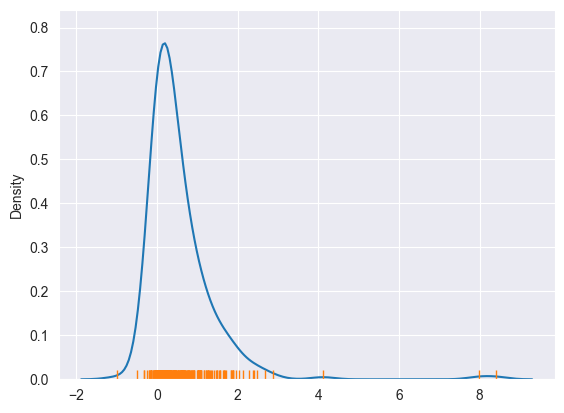

In [30]:
# Visualizing the density diagram of the local moran values (to compare between positive and negative SAC)
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

The distribution of the local moran's I is positively skewed, indicating the dominance of positive SAC values compared to negative ones. Further investigation is needed to identify which trend is observed more and in which regions:  HIGH-HIGH or LOW-LOW.

#### Chloropleth maps (local values, p-values, HH-LL)

In [31]:
# resetting gdf_index before storing new columns
gdf_lvl2.reset_index(inplace=True)

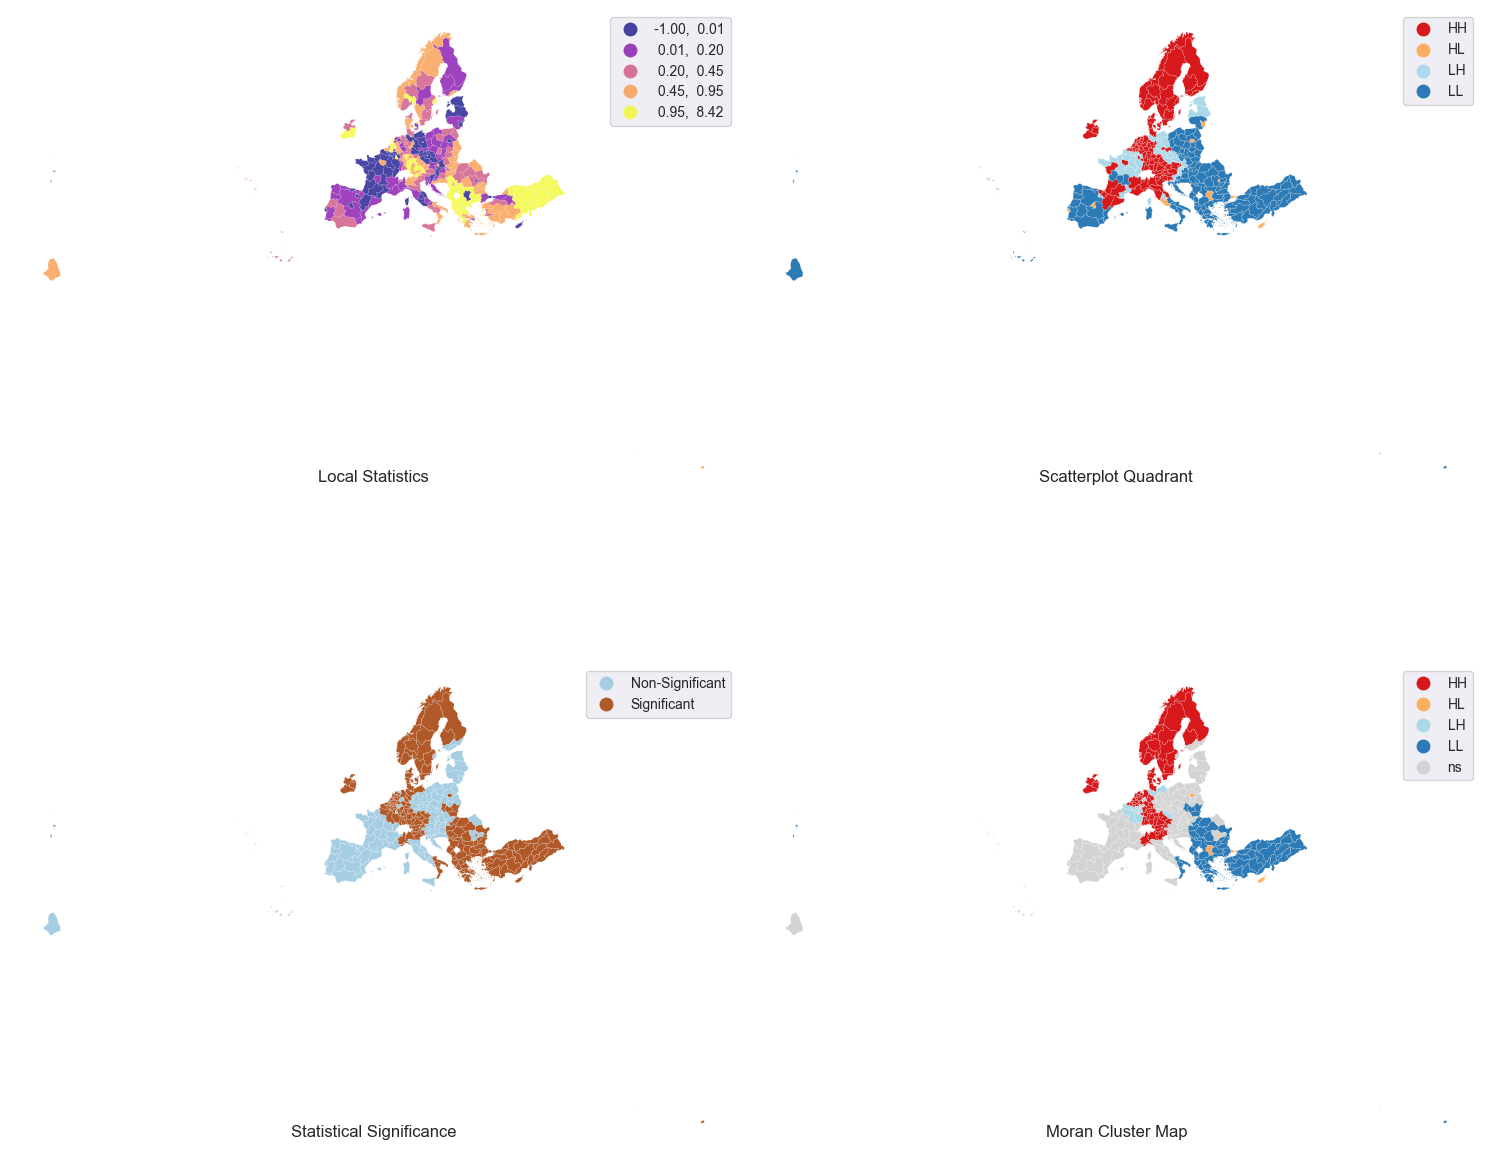

In [32]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
gdf_lvl2.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, gdf_lvl2, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=gdf_lvl2.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
gdf_lvl2.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)

# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf_lvl2, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

# Adding lisa and significance column to df
numpy_df = pandas.DataFrame(lisa.Is, columns=['LISA_VALUE'])
gdf_lvl2['LISA_VALUE'] = numpy_df['LISA_VALUE']

series_df = labels.to_frame(name='LISA_sig')
gdf_lvl2['LISA_sig'] = series_df['LISA_sig']

# Get p-values from Local Moran's I
p_values = lisa.p_sim
# Create a DataFrame with the extracted p-values
p_values_df = pandas.DataFrame(p_values, columns=['LISA_p_values'])
gdf_lvl2['LISA_p_values'] = p_values_df['LISA_p_values']

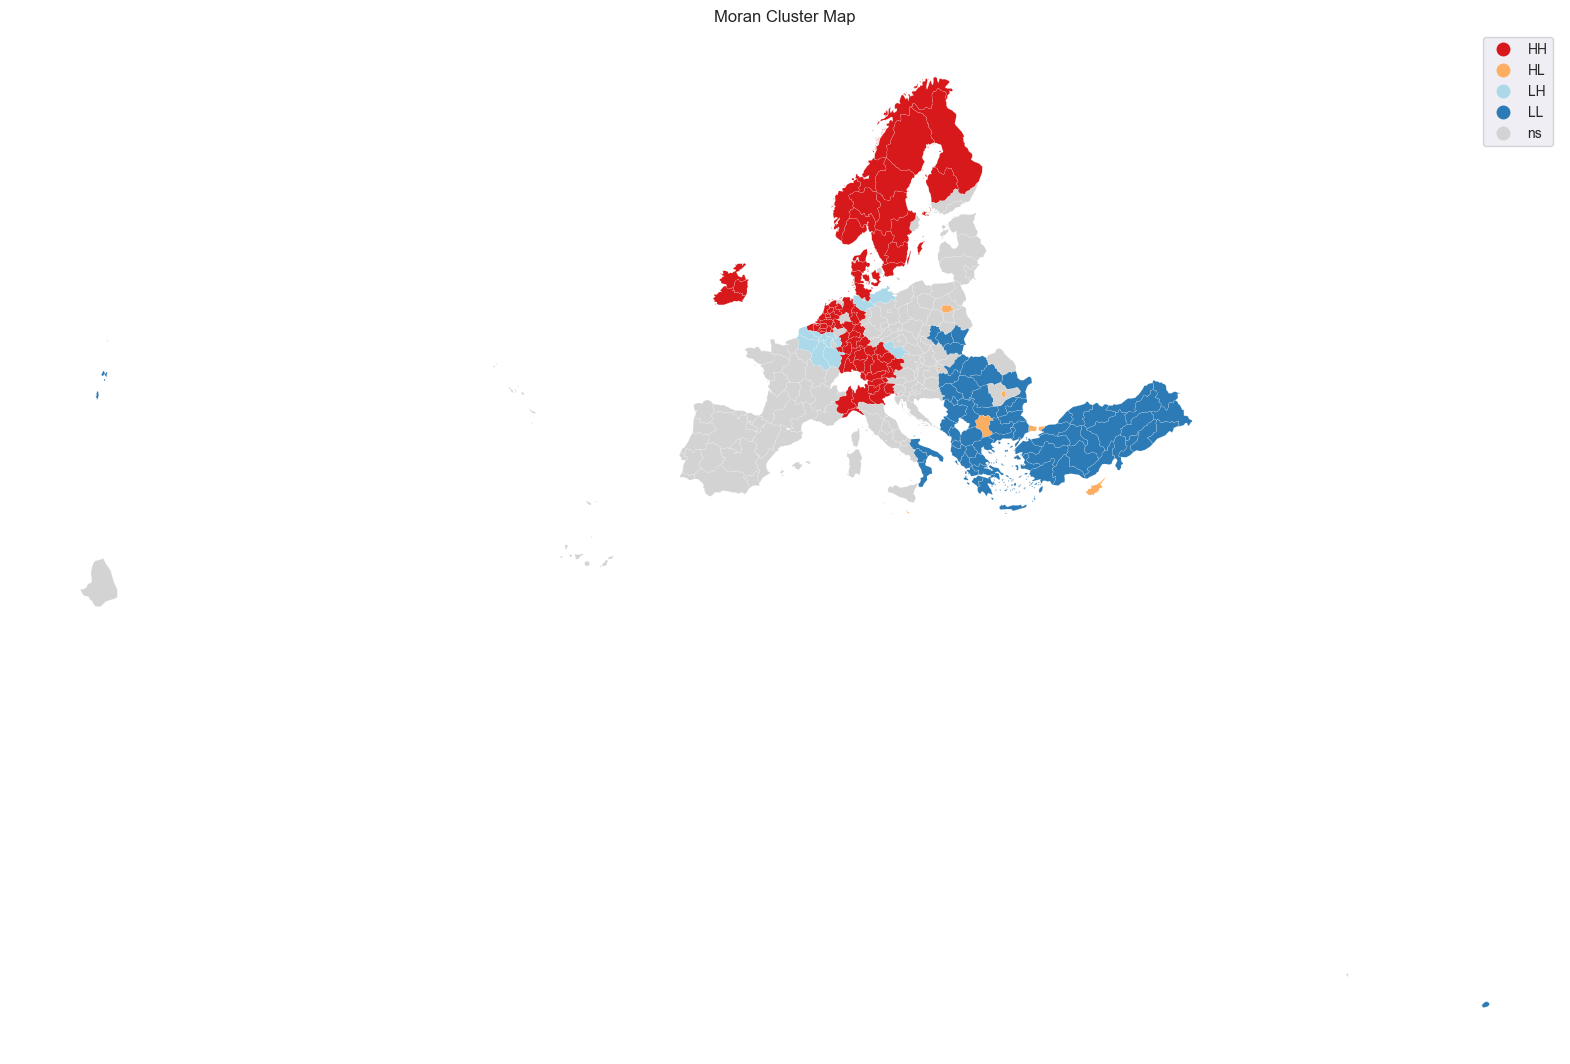

In [33]:
# Plot Quadrant colors with interactivity
fig, ax = plt.subplots(figsize=(20, 20))

# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, gdf_lvl2, p=0.05, ax=ax)
ax.set_title("Moran Cluster Map")

# Display the figure
plt.show()

## Relevant regions pairs (novel function)

Since the global spatial autocorrelation is seen to be positive (+0.56), we can employ the following novel function to create pairs of regions with values that are interesting to observe. Since these correlations arise despite the presence of positive spatial autocorrelation. Essentially, if two regions have similar values are in the LISA range of each other, these regions are no longer interesting to observe. However, two regions that have dissimilar values that are in LISA range of each other is interesting to observe since this is not the general trend. Finally, two regions that are out of LISA range of each other, is also recorded as interesting since the effects of spatial autocorrelation no longer apply.

In [34]:
lisa_df = gdf_lvl2.copy()

# converting NANs to float values in LISA_value and p-value column
lisa_df['LISA_VALUE'].fillna(0.0, inplace=True)
lisa_df['LISA_p_values'].fillna(0.0, inplace=True)

lisa_df

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,LISA_VALUE,LISA_sig,LISA_p_values
0,AL01,Veri,Veri,8200.0,"POLYGON ((5129579.170 2204098.752, 5148385.473...",5.147918e+06,2.148188e+06,2.028676,Significant,0.001
1,AL02,Qender,Qender,12300.0,"POLYGON ((5148777.300 2099959.278, 5178238.968...",5.166092e+06,2.059374e+06,1.634012,Significant,0.001
2,AL03,Jug,Jug,9300.0,"POLYGON ((5247352.798 2040320.505, 5257241.465...",5.183507e+06,1.987414e+06,1.844336,Significant,0.001
3,AT11,Burgenland,Burgenland,28300.0,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,-0.015556,Non-Significant,0.185
4,AT12,Niederösterreich,Niederösterreich,33400.0,"POLYGON ((4742889.368 2876362.725, 4783217.798...",4.748503e+06,2.811574e+06,0.155457,Non-Significant,0.076
...,...,...,...,...,...,...,...,...,...,...
278,TRB1,"Malatya, Elazığ, Bingöl, Tunceli","Malatya, Elazığ, Bingöl, Tunceli",11900.0,"POLYGON ((6874779.807 2348344.184, 6890718.965...",6.810685e+06,2.236288e+06,1.870558,Significant,0.001
279,TRB2,"Van, Muş, Bitlis, Hakkari","Van, Muş, Bitlis, Hakkari",7400.0,"POLYGON ((7079743.967 2368049.187, 7090192.978...",7.131402e+06,2.329574e+06,2.470744,Significant,0.001
280,TRC1,"Gaziantep, Adıyaman, Kilis","Gaziantep, Adıyaman, Kilis",14400.0,"POLYGON ((6820569.117 2163902.580, 6827627.296...",6.739547e+06,2.038815e+06,1.477510,Significant,0.001
281,TRC2,"Şanlıurfa, Diyarbakır","Şanlıurfa, Diyarbakır",7200.0,"POLYGON ((6989716.599 2273670.524, 6982786.486...",6.883662e+06,2.122830e+06,2.405219,Significant,0.001


In [36]:
# Extracting neighbors for each region
neighbors = w_adaptive.neighbors

# Removing the region itself from its neighbors list
for key, neighbor_list in neighbors.items():
    neighbors[key] = [neighbor for neighbor in neighbor_list if neighbor != key]

# Identifying threshold to consider as positive local SAC or negative local SAC
pos_lisa = 0.5
neg_lisa = 0.0

In [41]:
def calculate_interesting_correlations(lisa_df, neighbors):
    # Initialize empty lists and dictionaries to store interesting correlation pairs
    global i_gdp
    No_SAC_dict = dict()
    negative_SAC_dict = dict()
    for region_i in neighbors:
        No_SAC = []
        negative_SAC = []
        for region_j in neighbors[region_i]:
            # store the significance of each region
            lisa_i_sig = lisa_df.loc[lisa_df['NUTS_ID'] == region_i, 'LISA_sig'].iloc[0]
            lisa_j_sig = lisa_df.loc[lisa_df['NUTS_ID'] == region_j, 'LISA_sig'].iloc[0]
            # store the lisa values of each region
            lisa_i = lisa_df.loc[lisa_df['NUTS_ID'] == region_i, 'LISA_VALUE'].iloc[0]
            lisa_j = lisa_df.loc[lisa_df['NUTS_ID'] == region_j, 'LISA_VALUE'].iloc[0]
            # store the gdp values of each region
            i_gdp = lisa_df.loc[lisa_df['NUTS_ID'] == region_i, 'GDP_VALUE'].iloc[0]
            j_gdp = lisa_df.loc[lisa_df['NUTS_ID'] == region_j, 'GDP_VALUE'].iloc[0]
            # Significant lisa scores for region i and j
            if lisa_i_sig == 'Significant' and lisa_j_sig == 'Significant':
                # Condition 1: region i or j has positive SAC while other has negative SAC
                if (lisa_i > pos_lisa and lisa_j < neg_lisa) or (lisa_i < neg_lisa and lisa_j > pos_lisa):
                    negative_SAC.append((region_j, j_gdp))
                # Condition 2: region i or region j has no SAC
                if lisa_i == 0.0 or lisa_j == 0.0:
                    No_SAC.append((region_j, j_gdp))
                # Condition 3 : both have positive SAC so then region not stored
            # Non-Significant lisa scores for region i and j
            elif lisa_i_sig == 'Non-Significant' and lisa_j_sig == 'Non-Significant':
                No_SAC.append((region_j, j_gdp))
        if len(No_SAC) > 0:
            No_SAC_dict[(region_i, i_gdp)] = No_SAC
        if len(negative_SAC) > 0:
            negative_SAC_dict[(region_i, i_gdp)] = negative_SAC
    return No_SAC_dict, negative_SAC_dict

calculate_interesting_correlations(lisa_df, neighbors)[1]

{('AL01', 8200.0): [('BG41', 31000.0)],
 ('AL02', 12300.0): [('BG41', 31000.0)],
 ('AL03', 9300.0): [('BG41', 31000.0)],
 ('AT31', 41500.0): [('CZ03', 25000.0)],
 ('AT32', 46500.0): [('CZ03', 25000.0)],
 ('BE10', 65600.0): [('BE32', 24300.0),
  ('BE35', 25900.0),
  ('BE33', 27900.0),
  ('FRE1', 27400.0),
  ('BE34', 24000.0)],
 ('BE21', 46800.0): [('BE32', 24300.0), ('BE33', 27900.0), ('BE35', 25900.0)],
 ('BE23', 36800.0): [('BE32', 24300.0),
  ('FRE1', 27400.0),
  ('BE35', 25900.0),
  ('BE33', 27900.0)],
 ('BE24', 42600.0): [('BE32', 24300.0),
  ('BE35', 25900.0),
  ('BE33', 27900.0),
  ('BE34', 24000.0),
  ('FRE1', 27400.0)],
 ('BE25', 38700.0): [('FRE1', 27400.0),
  ('BE32', 24300.0),
  ('FRE2', 24800.0),
  ('BE35', 25900.0),
  ('BE33', 27900.0)],
 ('BE31', 46900.0): [('BE32', 24300.0),
  ('BE35', 25900.0),
  ('BE33', 27900.0),
  ('BE34', 24000.0),
  ('FRE1', 27400.0)],
 ('BE32', 24300.0): [('BE10', 65600.0),
  ('BE31', 46900.0),
  ('BE24', 42600.0),
  ('BE23', 36800.0),
  ('BE25', 

In [42]:
lisa_df[lisa_df['NUTS_ID']=='AT11']
# so found the issue!!! : When the non-significant lisa rows are removed we end up removing rows from the lisa dataframe
# that are still recorded as neighbors since the spatial weight matrix is calculated for all possible neighbors (no matter
# the lisa is significant or not
# Possible solution: in the neighborhood dictionary, create two lists, one for significant lisa neighbors and another for
# non-significant lisa values and then, the function above should work for significant lisa's and for the non-significant
# ones, we can define a special clause since if the lisa is significant for region i and not significant for j, can we consider this pair or not? yes we can use these since all this means is that the local spatial autocorrelation observed is not significant

# so would that not mean that if a region has a non-significant lisa value then, then it does not exhibit a staistically significant spatial autocorrelation with its neighbors and therefore, it can be considered to be part of interesting pairs?

,NUTS_ID,NUTS_NAME,NAME_LATN,GDP_VALUE,geometry,centroid_lon,centroid_lat,LISA_VALUE,LISA_sig,LISA_p_values
3,AT11,Burgenland,Burgenland,28300.0,"POLYGON ((4846489.857 2803511.391, 4854633.294...",4.811632e+06,2.736034e+06,-0.015556,Non-Significant,0.185


## Hypothesis testing attempt!

In [55]:
lisa_values = lisa.Is
lisa_values

array([ 2.02867570e+00,  1.63401227e+00,  1.84433639e+00, -1.55562552e-02,
        1.55457395e-01,  5.91811266e-01,  2.52057599e-01,  2.65671921e-01,
        7.60290602e-01,  1.35620184e+00,  9.21382937e-01,  1.40618235e+00,
        2.86251835e+00,  1.47549471e+00,  1.85599067e-01,  5.20370629e-01,
        9.77082993e-01,  5.42683021e-01,  1.15431468e+00, -2.42217538e-01,
       -6.93815357e-02, -3.14246315e-01, -1.89184233e-01,  1.08906914e+00,
        8.69544226e-01,  7.61695386e-01,  8.26886427e-01, -1.40085676e-01,
        1.25713268e+00, -8.51663010e-02,  1.22256526e+00, -1.00159913e-01,
       -1.47127159e-01, -1.92545025e-01, -2.40814756e-02, -3.26848468e-02,
        3.91284942e-02,  1.27888709e-01,  1.65301397e+00,  8.96325583e-01,
        4.20523345e-01,  1.06567225e+00,  2.66806007e+00,  6.39323341e-01,
        6.73201584e-01,  3.08456956e-01,  1.09554060e+00,  6.07379498e-01,
        7.44934201e-01,  9.10852011e-02, -3.46315311e-03,  1.08348103e+00,
        2.27404785e+00,  

In [56]:
lisa.p_sim

array([0.001, 0.001, 0.001, 0.181, 0.08 , 0.226, 0.041, 0.078, 0.015,
       0.005, 0.002, 0.004, 0.026, 0.003, 0.005, 0.007, 0.005, 0.015,
       0.017, 0.014, 0.005, 0.001, 0.008, 0.005, 0.014, 0.027, 0.006,
       0.001, 0.002, 0.001, 0.302, 0.077, 0.039, 0.076, 0.264, 0.099,
       0.446, 0.196, 0.005, 0.018, 0.024, 0.004, 0.007, 0.007, 0.025,
       0.055, 0.004, 0.011, 0.001, 0.439, 0.323, 0.028, 0.079, 0.026,
       0.039, 0.039, 0.039, 0.076, 0.024, 0.005, 0.029, 0.028, 0.048,
       0.039, 0.054, 0.035, 0.016, 0.009, 0.007, 0.011, 0.279, 0.175,
       0.227, 0.098, 0.009, 0.056, 0.084, 0.004, 0.01 , 0.021, 0.011,
       0.081, 0.001, 0.011, 0.003, 0.006, 0.002, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.002, 0.2  , 0.34 , 0.443, 0.456,
       0.393, 0.367, 0.434, 0.186, 0.346, 0.37 , 0.132, 0.451, 0.408,
       0.4  , 0.076, 0.154, 0.064, 0.086, 0.087, 0.031, 0.119, 0.053,
       0.026, 0.025, 0.365, 0.287, 0.319, 0.241, 0.269, 0.162, 0.024,
       0.037, 0.032,

In [58]:
import numpy as np
from scipy.stats import percentileofscore
def calculate_lisa_p_values(lisa_values, num_permutations=10000):
    """
    Calculate p-values for Local Indicators of Spatial Association (LISA) values.

    Parameters:
    lisa_values (array-like): Array of LISA values.
    num_permutations (int): Number of permutations for generating the null distribution.

    Returns:
    array: Array of p-values for each LISA value.
    """
    n = len(lisa_values)
    permuted_lisas = np.zeros((num_permutations, n))
    p_values = np.zeros(n)

    # Generate permuted LISA values
    for i in range(num_permutations):
        permuted_lisas[i] = np.random.permutation(lisa_values)

    # Calculate p-values
    for i, lisa_value in enumerate(lisa_values):
        p_values[i] = percentileofscore(permuted_lisas[:, i], lisa_value) / 100

    return p_values

In [62]:
def calculate_lisa_p_values(lisa_values, num_permutations=999):
    """
    Calculate p-values for Local Indicators of Spatial Association (LISA) values using permutation.

    Parameters:
    lisa_values (array-like): Array of LISA values.
    num_permutations (int): Number of permutations for generating the null distribution.

    Returns:
    array: Array of p-values for each LISA value.
    """
    n = len(lisa_values)
    p_values = np.zeros(n)

    # Compute observed statistics
    obs_statistics = np.abs(lisa_values)

    # Permute values and compute statistics
    for i in range(num_permutations):
        permuted_values = np.random.permutation(lisa_values)
        permuted_statistics = np.abs(permuted_values)

        # Increment p-values if permuted statistic exceeds observed statistic
        p_values += (permuted_statistics >= obs_statistics)

    # Normalize p-values
    p_values /= num_permutations

    return p_values

In [63]:
import numpy as np
from scipy.stats import norm

def compute_lisa_p_values(lisa_values):
    """
    Compute p-values for LISA values using normal approximation.

    Parameters:
    lisa_values (array-like): Array of LISA values.

    Returns:
    array: Array of p-values for each LISA value.
    """
    # Calculate expected value (mean) and variance of LISA values
    mean_lisa = np.mean(lisa_values)
    var_lisa = np.var(lisa_values)

    # Calculate test statistic (z-score)
    z_scores = (lisa_values - mean_lisa) / np.sqrt(var_lisa)

    # Calculate two-tailed p-values
    p_values = 2 * norm.cdf(-np.abs(z_scores))

    return p_values

In [66]:
# Example array of LISA values
# lisa_values = np.array([0.2, 0.3, 0.1, 0.5, 0.4])

# Calculate p-values for LISA values
p_values = calculate_lisa_p_values(lisa_values)

# Print the LISA values and corresponding p-values
print("P-Values:", p_values)

P-Values: [0.03403403 0.07107107 0.06106106 0.92892893 0.71171171 0.35135135
 0.54754755 0.51951952 0.26726727 0.11911912 0.2012012  0.10710711
 0.01001001 0.10710711 0.61861862 0.38738739 0.19019019 0.38438438
 0.13913914 0.58158158 0.78378378 0.5015015  0.5995996  0.15615616
 0.21821822 0.23923924 0.23923924 0.67967968 0.12112112 0.76676677
 0.14514515 0.76776777 0.7007007  0.62962963 0.91691692 0.85785786
 0.85385385 0.68768769 0.07807808 0.2002002  0.43143143 0.17417417
 0.01701702 0.28628629 0.3003003  0.47147147 0.13813814 0.33533534
 0.27627628 0.77177177 0.97397397 0.14714715 0.02702703 0.13613614
 0.5995996  0.56256256 0.84484484 0.28528529 0.41141141 0.73373373
 0.58058058 0.35735736 0.37937938 0.69269269 0.43643644 0.62462462
 0.61361361 0.8998999  0.28328328 0.57257257 0.90790791 0.89489489
 0.82182182 0.92892893 0.62962963 0.88088088 0.06606607 0.91691692
 0.37037037 0.31031031 0.51051051 0.87887888 0.81781782 0.18518519
 0.36136136 0.24724725 0.15415415 0.18918919 0.16016

In [65]:
lisa.p_sim

array([0.001, 0.001, 0.001, 0.181, 0.08 , 0.226, 0.041, 0.078, 0.015,
       0.005, 0.002, 0.004, 0.026, 0.003, 0.005, 0.007, 0.005, 0.015,
       0.017, 0.014, 0.005, 0.001, 0.008, 0.005, 0.014, 0.027, 0.006,
       0.001, 0.002, 0.001, 0.302, 0.077, 0.039, 0.076, 0.264, 0.099,
       0.446, 0.196, 0.005, 0.018, 0.024, 0.004, 0.007, 0.007, 0.025,
       0.055, 0.004, 0.011, 0.001, 0.439, 0.323, 0.028, 0.079, 0.026,
       0.039, 0.039, 0.039, 0.076, 0.024, 0.005, 0.029, 0.028, 0.048,
       0.039, 0.054, 0.035, 0.016, 0.009, 0.007, 0.011, 0.279, 0.175,
       0.227, 0.098, 0.009, 0.056, 0.084, 0.004, 0.01 , 0.021, 0.011,
       0.081, 0.001, 0.011, 0.003, 0.006, 0.002, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.002, 0.2  , 0.34 , 0.443, 0.456,
       0.393, 0.367, 0.434, 0.186, 0.346, 0.37 , 0.132, 0.451, 0.408,
       0.4  , 0.076, 0.154, 0.064, 0.086, 0.087, 0.031, 0.119, 0.053,
       0.026, 0.025, 0.365, 0.287, 0.319, 0.241, 0.269, 0.162, 0.024,
       0.037, 0.032,

# Stationarity of time series?

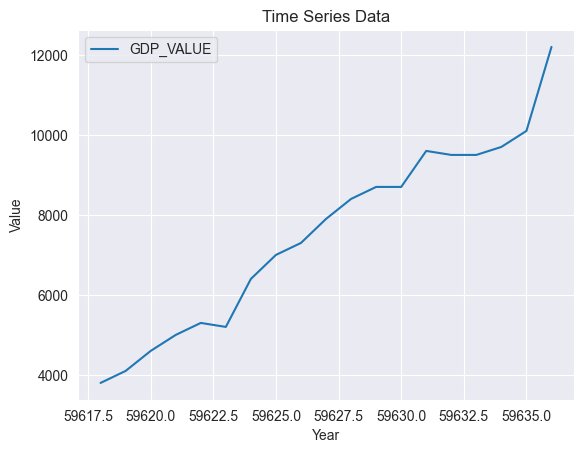

ADF Test Results:
ADF Statistic: 0.3872533427239021
p-value: 0.9810119538410471
Critical Values: {'1%': -3.859073285322359, '5%': -3.0420456927297668, '10%': -2.6609064197530863}

KPSS Test Results:
KPSS Statistic: 0.743186860206792
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\20211147\AppData\Local\Temp\ipykernel_9996\3860589478.py:24: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(ts_data)


In [77]:
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

ts_data = gdp_df[gdp_df['NUTS_ID']=='TRC3']
ts_data = ts_data.drop(columns=['NUTS_ID','TIME_PERIOD'])

# Plot the time series data
ts_data.plot()
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

# Perform ADF test
adf_result = adfuller(ts_data)
print('ADF Test Results:')
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:', adf_result[4])

## p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. Thereby, inferring that the series is stationary.

# Perform KPSS test
kpss_result = kpss(ts_data)
print('\nKPSS Test Results:')
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])
print('Critical Values:', kpss_result[3])

## P-value obtained should be greater than chosen significance level (say 0.05) -> cannot reject null and thus conclude stationary time series